# Controlled-XY trotter

In [ ]:
import numpy as np
import quimb as qu
import quimb.tensor as qtn

# ---- compatibility patch for some quimb/autoray versions ----
if not hasattr(qu, "transpose"):
    qu.transpose = np.transpose


def _as_np(x):
    return np.asarray(x, dtype=complex)


def exp_i_theta_xx_yy(theta):
    c = np.cos(2.0 * theta)
    s = 1j * np.sin(2.0 * theta)
    return _as_np([
        [1.0, 0.0, 0.0, 0.0],
        [0.0,   c,   s, 0.0],
        [0.0,   s,   c, 0.0],
        [0.0, 0.0, 0.0, 1.0],
    ])
    
def exp_i_theta_ZZ(theta):
    return _as_np([
        [np.exp(1j* theta), 0.0, 0.0, 0.0],
        [0.0, np.exp(-1j* theta), 0.0, 0.0],
        [0.0, 0.0, np.exp(-1j* theta), 0.0],
        [0.0, 0.0, 0.0, np.exp(1j* theta)],
    ])


P0 = _as_np([[1, 0],
             [0, 0]])
P1 = _as_np([[0, 0],
             [0, 1]])


def mpo_identity_arrays(L, d=2):
    """Identity MPO with *rank-3 boundaries*: left is (r,u,d), right is (l,u,d)."""
    I = _as_np(np.eye(d))
    arrs = []
    for s in range(L):
        if s == 0:
            arrs.append(I.reshape(1, d, d).copy())      # (Dr=1, u, d) == "rud"
        elif s == L - 1:
            arrs.append(I.reshape(1, d, d).copy())      # (Dl=1, u, d) == "lud"
        else:
            arrs.append(I.reshape(1, 1, d, d).copy())   # (Dl, Dr, u, d) == "lrud"
    return arrs


def mpo_from_arrays(arrs, *, upper_ind_id="k{}", lower_ind_id="b{}"):
    """
    Build MPO from a mix of:
      left boundary:  (Dr, u, d)
      middle:         (Dl, Dr, u, d)
      right boundary: (Dl, u, d)
    with shape='lrud' telling quimb what order these correspond to.
    """
    L = len(arrs)
    arrs = [_as_np(A) for A in arrs]
    return qtn.MatrixProductOperator(
        arrs,
        sites=range(L),
        shape="lrud",
        upper_ind_id=upper_ind_id,
        lower_ind_id=lower_ind_id,
    )


def _set_site_tensor_with_boundary(arrs, s, W):
    """
    Put a rank-4 site tensor W[Dl,Dr,u,d] into arrs[s], but if s is a boundary,
    drop the missing bond index to make it rank-3 as desired.
    """
    W = _as_np(W)
    if s == 0:
        # want (Dr,u,d) -> drop Dl (assumed 1)
        if W.shape[0] != 1:
            raise ValueError("Left boundary expects Dl=1.")
        arrs[s] = W[0, :, :, :]          # (Dr,u,d)
    elif s == len(arrs) - 1:
        # want (Dl,u,d) -> drop Dr (assumed 1)
        if W.shape[1] != 1:
            raise ValueError("Right boundary expects Dr=1.")
        arrs[s] = W[:, 0, :, :]          # (Dl,u,d)
    else:
        arrs[s] = W                      # (Dl,Dr,u,d)


def mpo_two_site_gate_nonlocal(L, j, k, U2, *, svd_cutoff=1e-12):
    if j == k:
        raise ValueError("Need two distinct sites.")
    if j > k:
        j, k = k, j

    d = 2
    U2 = _as_np(U2)

    # U2 -> (out_j,out_k,in_j,in_k) then to (out_j,in_j) x (out_k,in_k)
    U = U2.reshape(d, d, d, d)
    U = np.transpose(U, (0, 2, 1, 3))
    M = U.reshape(d * d, d * d)

    Uu, Ss, Vh = np.linalg.svd(M, full_matrices=False)
    keep = np.where(Ss > svd_cutoff)[0]
    Uu = Uu[:, keep]
    Ss = Ss[keep]
    Vh = Vh[keep, :]

    r = len(Ss)
    sqrtS = np.sqrt(Ss)

    Aops = [(Uu[:, a] * sqrtS[a]).reshape(d, d) for a in range(r)]
    Bops = [(Vh[a, :] * sqrtS[a]).reshape(d, d) for a in range(r)]

    arrs = mpo_identity_arrays(L, d=d)
    I = _as_np(np.eye(d))

    # site j core tensor: (Dl=1, Dr=r, u, d)
    Aj = np.zeros((1, r, d, d), dtype=complex)
    for a in range(r):
        Aj[0, a, :, :] = Aops[a]
    _set_site_tensor_with_boundary(arrs, j, Aj)

    # middle propagation tensors: (Dl=r, Dr=r, u, d)
    for s in range(j + 1, k):
        W = np.zeros((r, r, d, d), dtype=complex)
        for a in range(r):
            W[a, a, :, :] = I
        # NOTE: if s is boundary (can only happen if L=2, but then no middle), safe anyway
        _set_site_tensor_with_boundary(arrs, s, W)

    # site k core tensor: (Dl=r, Dr=1, u, d)
    Bk = np.zeros((r, 1, d, d), dtype=complex)
    for a in range(r):
        Bk[a, 0, :, :] = Bops[a]
    _set_site_tensor_with_boundary(arrs, k, Bk)

    return mpo_from_arrays(arrs)


def mpo_XY_pairs(L, pairs, theta, *, max_bond=None, cutoff=1e-12, svd_cutoff=1e-12):
    U2 = exp_i_theta_xx_yy(theta)
    mpo = mpo_from_arrays(mpo_identity_arrays(L))
    for (j, k) in pairs:
        mpo_jk = mpo_two_site_gate_nonlocal(L, j, k, U2, svd_cutoff=svd_cutoff)
        mpo = mpo_jk.apply(mpo, compress=True, max_bond=max_bond, cutoff=cutoff)
    return mpo

def mpo_rand_ZZ_pairs(L, pairs, W, *, max_bond=None, cutoff=1e-12, svd_cutoff=1e-12):
    mpo = mpo_from_arrays(mpo_identity_arrays(L))
    for (j, k) in pairs:
        theta = W*np.pi*(2*np.random.random()-1.)
        U2 = exp_i_theta_ZZ(theta)
        mpo_jk = mpo_two_site_gate_nonlocal(L, j, k, U2, svd_cutoff=svd_cutoff)
        mpo = mpo_jk.apply(mpo, compress=True, max_bond=max_bond, cutoff=cutoff)
    return mpo

def multi_controlled_pairs_mpo(L, controls, pairs, theta, *,
                               max_bond=None, cutoff=1e-12, svd_cutoff=1e-12):
    """
    MPO for:
      (I - Π_c P1(c)) ⊗ I   +   (Π_c P1(c)) ⊗ U_pairs
    equivalently:
      Π_c P0(c) ⊗ I + Π_c P1(c) ⊗ U_pairs  only if there is exactly one control,
    but for multiple controls the 'else' branch should be identity whenever any control is 0.

    Here we implement:
      mpo = mpo_else + mpo_then
    where:
      mpo_then = (Π_c P1(c)) ⊗ U_pairs
      mpo_else = I - (Π_c P1(c)) ⊗ I
    so total is identity unless all controls are 1.
    """
    controls = tuple(controls)
    if len(controls) == 0:
        # no controls: just return U_pairs
        return mpo_XY_pairs(L, pairs, theta, max_bond=max_bond, cutoff=cutoff, svd_cutoff=svd_cutoff)

    # validate controls
    if len(set(controls)) != len(controls):
        raise ValueError("Duplicate control indices.")
    for c in controls:
        if not (0 <= c < L):
            raise ValueError(f"Control index {c} outside [0, L).")

    # validate pairs (disjoint + don't touch controls)
    used = set()
    for (j, k) in pairs:
        if j == k:
            raise ValueError(f"Pair {(j, k)} has j==k.")
        if j in controls or k in controls:
            raise ValueError(f"Control appears in pair {(j, k)}.")
        if j in used or k in used:
            raise ValueError("Pairs overlap (share a site).")
        used.add(j); used.add(k)

    # U_pairs
    mpoU = mpo_XY_pairs(L, pairs, theta, max_bond=max_bond, cutoff=cutoff, svd_cutoff=svd_cutoff)

    # Π_c P1(c) as an MPO (diagonal projectors placed locally)
    arrP1 = mpo_identity_arrays(L)
    for c in controls:
        W = P1.reshape(1, 1, 2, 2)
        _set_site_tensor_with_boundary(arrP1, c, W)
    mpoAll1 = mpo_from_arrays(arrP1)

    # THEN branch: (Π_c P1(c)) ⊗ U_pairs
    mpo_then = mpoAll1.apply(mpoU, max_bond=max_bond, cutoff=cutoff)

    # ELSE branch: I - (Π_c P1(c)) ⊗ I
    # Build I as an MPO:
    mpoI = mpo_from_arrays(mpo_identity_arrays(L))
    # The (Π_c P1(c)) ⊗ I is just mpoAll1 itself (since other sites are identity ops)
    mpo_else = mpoI - mpoAll1

    mpo = mpo_else + mpo_then
    mpo.compress(max_bond=max_bond, cutoff=cutoff)
    return mpo

def MCXY_trotter_step_mpos(n, q, dt, max_bond=None, cutoff=1e-10, svd_cutoff=1e-14):
    Q = n * q
    
    even_pairs = [(i, i+1) for i in range(0, q-1, 2)]
    odd_pairs = [(i, i+1) for i in range(1, q-1, 2)]
    
    even_mpos = [mpo_XY_pairs(Q, even_pairs, dt, max_bond=max_bond, cutoff=cutoff, svd_cutoff=svd_cutoff)]
    odd_mpos = [mpo_XY_pairs(Q, odd_pairs, dt, max_bond=max_bond, cutoff=cutoff, svd_cutoff=svd_cutoff)]
    
    if q % 2 == 0:
        for l in range(1, n):
            even_controls = [q*lp for lp in range(l-1)] + [q*l - 1]
            odd_controls = [q*lp for lp in range(l)] 
            
            even_pairs = [(q*l+i, q*l+i+1) for i in range(0, q-1, 2)]
            odd_pairs = [(q*l+i, q*l+i+1) for i in range(1, q-1, 2)]
            
            even_mpos.append(multi_controlled_pairs_mpo(Q, even_controls, even_pairs, dt, max_bond=max_bond, cutoff=cutoff, svd_cutoff=svd_cutoff))
            odd_mpos.append(multi_controlled_pairs_mpo(Q, odd_controls, odd_pairs, dt, max_bond=max_bond, cutoff=cutoff, svd_cutoff=svd_cutoff))
    
    elif q % 2 == 1:
        for l in range(1, n):
            even_controls = [q*lp-1 for lp in range(1, l+1)]
            odd_controls = [q*lp for lp in range(l)] 
            
            even_pairs = [(q*l+i, q*l+i+1) for i in range(0, q-1, 2)]
            odd_pairs = [(q*l+i, q*l+i+1) for i in range(1, q-1, 2)]
            
            even_mpos.append(multi_controlled_pairs_mpo(Q, even_controls, even_pairs, dt, max_bond=max_bond, cutoff=cutoff, svd_cutoff=svd_cutoff))
            odd_mpos.append(multi_controlled_pairs_mpo(Q, odd_controls, odd_pairs, dt, max_bond=max_bond, cutoff=cutoff, svd_cutoff=svd_cutoff))
    
    return even_mpos, odd_mpos

# W = disorder strength
def randZZ_trotter_step_mpos(n, q, dt, W, max_bond=None, cutoff=1e-10, svd_cutoff=1e-14):
    Q = n * q
    
    even_pairs = [(i, i+1) for i in range(0, q-1, 2)]
    odd_pairs = [(i, i+1) for i in range(1, q-1, 2)]
    
    even_mpos = [mpo_rand_ZZ_pairs(Q, even_pairs, W*dt, max_bond=max_bond, cutoff=cutoff, svd_cutoff=svd_cutoff)] 
    odd_mpos = [mpo_rand_ZZ_pairs(Q, odd_pairs, W*dt, max_bond=max_bond, cutoff=cutoff, svd_cutoff=svd_cutoff)]
    
    return even_mpos, odd_mpos

# W = disorder strength
def trotter_evolution(init_mps, n, q, dt, W, n_steps,
                      max_bond=None, cutoff=1e-10, svd_cutoff=1e-14):
    """
    Yield the MPS after each full Trotter step.
    First yield is the initial state.
    """
    XY_even_mpos, XY_odd_mpos = MCXY_trotter_step_mpos(
        n, q, dt,
        max_bond=None,
        cutoff=cutoff,
        svd_cutoff=svd_cutoff,
    )
    
    ZZ_even_mpos, ZZ_odd_mpos = randZZ_trotter_step_mpos(
        n, q, dt, W,
        max_bond=None,
        cutoff=cutoff,
        svd_cutoff=svd_cutoff,)
    
    trotter_mpos = XY_even_mpos + ZZ_even_mpos + XY_odd_mpos + ZZ_odd_mpos

    cur_mps = init_mps
    yield (cur_mps, 1.0)   # t = 0

    for _ in range(n_steps):
        perfect_mps = cur_mps.copy()
        for mpo in trotter_mpos:
            perfect_mps = mpo.apply(
                perfect_mps,
                compress=False
            )
        perfect_mps.normalize()
        
        new_mps = cur_mps.copy()
        for mpo in trotter_mpos:
            new_mps = mpo.apply(
                new_mps,
                compress=True,
                max_bond=max_bond,
                cutoff=cutoff,
            )
        new_mps.normalize()
        
        cur_mps = new_mps
        yield (cur_mps, np.abs(perfect_mps.H @ cur_mps))


if __name__ == "__main__":
    q = 4
    n = 2
    dt = 0.5
    W = 1
    n_steps = 50

    '''
    init_bitstring = ["0"]*(q*n)
    init_bitstring[0] = '1'
    init_bitstring[q] = '1'
    init_bitstring = "".join(init_bitstring)
    print(init_bitstring)
    init_mps = qtn.MPS_computational_state(init_bitstring)
    
    for mps in trotter_evolution(init_mps, n, q, dt, W, n_steps):
        mps.show()
    '''

# Constructing one-hot basis

In [1]:
import numpy as np

def reflected_qary_gray_digits(n, q):
    """Reflected q-ary Gray code on n digits (MSD changes slowest)."""
    if n < 0 or q <= 0:
        raise ValueError("Need n>=0, q>0.")
    if n == 0:
        return [()]
    prev = reflected_qary_gray_digits(n - 1, q)
    out = []
    for a in range(q):
        block = prev if (a % 2 == 0) else prev[::-1]
        out.extend((a,) + t for t in block)
    return out


def one_hot_bounce_bitstrings(n, q, *, as_str=True, dtype=np.int8):
    """
    Now: the *first* register is the fastest-changing one.
    """
    digits_list = reflected_qary_gray_digits(n, q)

    if as_str:
        bitstrings = []
        for digits in digits_list:
            # ---- KEY FIX: reverse digit order when mapping to registers ----
            digits = digits[::-1]
            chunks = []
            for d in digits:
                reg = ['0'] * q
                reg[d] = '1'
                chunks.append(''.join(reg))
            bitstrings.append(''.join(chunks))
        return bitstrings

    out = np.zeros((len(digits_list), n * q), dtype=dtype)
    for row, digits in enumerate(digits_list):
        digits = digits[::-1]  # ---- KEY FIX ----
        for r, d in enumerate(digits):
            out[row, r * q + d] = 1
    return out

def mps_overlap_profile(mps, bs):
    vals = []
    for b in bs:
        b_mps = qtn.MPS_computational_state(b)
        vals.append(mps @ b_mps)
    return vals

# Save Trotter MPSs

In [21]:
from pathlib import Path

## one-hot center_delta

In [21]:
# initial state = a delta state in the center

D = 1
n = 2
q = 8
dt = 0.1
n_steps = 100
max_bond = None
W = 0.0
instance=0

'''
# folder, important to record
folder=f"MPS/one_hot/D={D}/n={n}/q={q}/dt={dt}/n_steps={n_steps}/max_bond={max_bond}/W={0.0}/init_state_center_delta/instance_{instance}"
Path(folder).mkdir(parents=True, exist_ok=True)

bs = one_hot_bounce_bitstrings(n, q, as_str=True)
init_mps = qtn.MPS_computational_state(bs[q**n//2])
qu.save_to_disk(init_mps, folder+"/step=0.mps")

for step, mps in enumerate(trotter_evolution(init_mps, n, q, dt, W, n_steps, max_bond=None), start=1):
    qu.save_to_disk(mps, folder+f"/step={step}.mps")
'''

'\n# folder, important to record\nfolder=f"MPS/one_hot/D={D}/n={n}/q={q}/dt={dt}/n_steps={n_steps}/max_bond={max_bond}/W={0.0}/init_state_center_delta/instance_{instance}"\nPath(folder).mkdir(parents=True, exist_ok=True)\n\nbs = one_hot_bounce_bitstrings(n, q, as_str=True)\ninit_mps = qtn.MPS_computational_state(bs[q**n//2])\nqu.save_to_disk(init_mps, folder+"/step=0.mps")\n\nfor step, mps in enumerate(trotter_evolution(init_mps, n, q, dt, W, n_steps, max_bond=None), start=1):\n    qu.save_to_disk(mps, folder+f"/step={step}.mps")\n'

# Plot fidelities

## one-hot center_delta

In [33]:
D = 1
n = 2
q = 16
dt = 0.1
n_steps = 100
max_bond = None
W = 0.0

fidelities_1 = []

bs = one_hot_bounce_bitstrings(n, q, as_str=True)
init_mps = qtn.MPS_computational_state(bs[q**n//2])
for mps, fidelity in trotter_evolution(init_mps, n, q, dt, W, n_steps, max_bond=4):
    mps.show()
    print(fidelity)
    fidelities_1.append(fidelity)

 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 
>─>─>─>─>─>─>─>─>─>─>─>─>─>─>─>─>─>─>─>─>─>─>─>─>─>─>─>─>─>─>─●
│ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │
1.0
 2 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 
●─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<
│ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │
1.0000000000000002
 2 3 3 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 
●─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<
│ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │
1.0000000000000002
 2 3 3 3 3 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 
●─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<
│ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │
1.0000000000000002
 2 3 3 3 3 3 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 
●─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<
│ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │

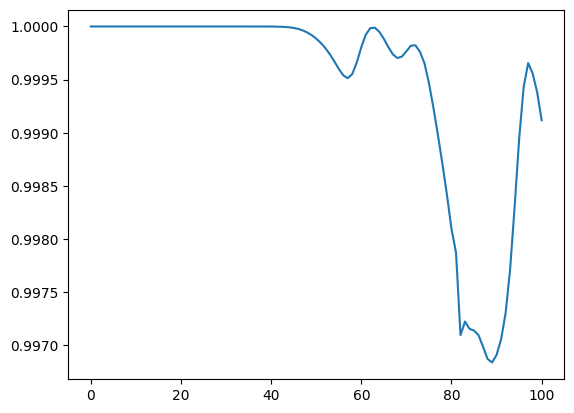

In [34]:
import matplotlib.pyplot as plt
plt.plot(fidelities_1)

## Binary

In [35]:
D = 1
n = 8
q = 2
dt = 0.1
n_steps = 100
max_bond = None
W = 0.0

fidelities_2 = []

bs = one_hot_bounce_bitstrings(n, q, as_str=True)
init_mps = qtn.MPS_computational_state(bs[q**n//2])
for mps, fidelity in trotter_evolution(init_mps, n, q, dt, W, n_steps, max_bond=4):
    mps.show()
    print(fidelity)
    fidelities_2.append(fidelity)

 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 
>─>─>─>─>─>─>─>─>─>─>─>─>─>─>─●
│ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │
1.0
 2 2 3 2 2 2 2 2 2 2 2 2 2 2 2 
●─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<
│ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │
1.0000000000000007
 2 2 4 3 3 2 2 2 2 2 2 2 2 2 2 
●─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<
│ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │
0.9999999999999989
 2 2 4 4 4 2 2 2 2 2 2 2 2 2 2 
●─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<
│ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │
1.0000000000000004
 2 2 4 4 4 2 2 2 2 2 2 2 2 2 2 
●─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<
│ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │
0.999999999997055
 2 2 4 4 4 2 2 2 2 2 2 2 2 2 2 
●─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<
│ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │
0.9999999998260014
 2 2 4 4 4 2 2 2 2 2 2 2 2 2 2 
●─●─●─●─●─●─●─●─●─●─●─●─●─●─●─●
│ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │
0.9999999968019848
 2 2 4 4 4 3 3 2 2 2 2 2 2 2 2 
●─●─●─●─●─●─●─●─●─●─●─●─●─●─●─●
│ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │
0.9999999684701146
 2 2 4 4 4 3 3 2 2 2 2 2 2 2 2 
●─●─●─●─●─●─●─●─●─●─●─●─●─●─●─●
│ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │


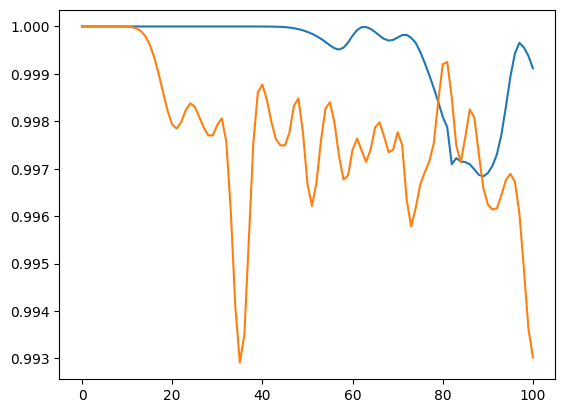

In [37]:
import matplotlib.pyplot as plt
plt.plot(fidelities_1)
plt.plot(fidelities_2)

# Plot Trotter

## Make bond_dim_profile and GIF

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
import imageio.v2 as imageio

def make_bond_dim_profile_and_gif_from_mps(mps_iter, mps_fn, *, fps=10):
    frames = []
    bond_dim_profile = []

    fig, ax = plt.subplots()
    line, = ax.plot([], [])
    ax.set_xlabel("index")
    ax.set_ylabel("value")

    for t, mps in enumerate(mps_iter):
        
        bond_sizes = mps.bond_sizes()
        bond_dim_profile.append(bond_sizes)
        
        y = np.asarray(mps_fn(mps), dtype=float)
        x = np.arange(len(y))

        line.set_data(x, y)
        ax.set_xlim(0, len(y) - 1 if len(y) else 1)
        ax.set_ylim(-1, 1)
        ax.set_title(f"t = {t}, {bond_sizes}")

        fig.canvas.draw()
        w, h = fig.canvas.get_width_height()
        img = np.frombuffer(fig.canvas.buffer_rgba(), dtype=np.uint8).reshape(h, w, 4)
        frames.append(img.copy())

    plt.close(fig)

    # write to bytes instead of disk
    import io
    buf = io.BytesIO()
    imageio.mimsave(buf, frames, format="GIF", duration=1.0/fps)
    buf.seek(0)

    return bond_dim_profile, Image(data=buf.read(), format="gif")


In [ ]:
import matplotlib.pyplot as plt

n = 2
q = 8
dt = 0.1
W = 1.0
n_steps = 100

bs = one_hot_bounce_bitstrings(n, q, as_str=True)
init_mps = qtn.MPS_computational_state(bs[q**n//2])
mps_fn = lambda mps: np.real(mps_overlap_profile(mps, bs))

mps_fidelity_iter = trotter_evolution(init_mps, n, q, dt, W, n_steps, max_bond=None)

bond_dim_profile_1, gif_1 = make_bond_dim_profile_and_gif_from_mps((mps for mps, _ in mps_fidelity_iter), 
                                                                mps_fn,
                                                                fps = 10)
#for t, bd in enumerate(bond_dim_profile_1):
#    print(f"t = {t}:", bd)

/home/jchen9/pauli_first_quantization/.venv/lib64/python3.9/site-packages/cotengra/hyperoptimizers/hyper.py:55: UserWarning: Couldn't find `optuna`, `cmaes`, or `nevergrad` so will use completely random sampling in place of hyper-optimization. It is recommended to install one of these libraries for higher quality contraction paths.
  warnings.warn(


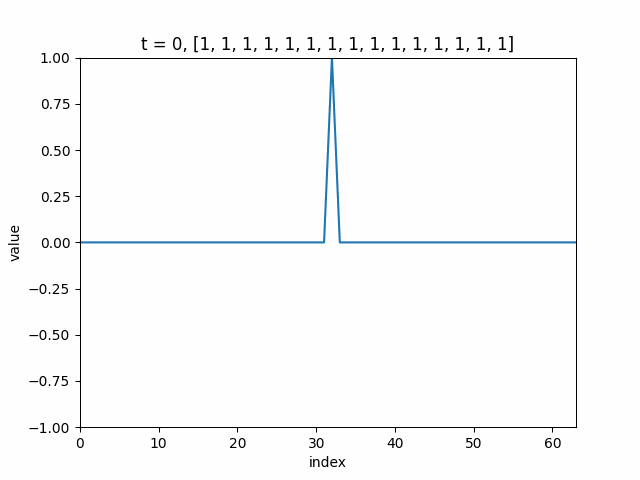

In [9]:
gif_1

In [ ]:
import matplotlib.pyplot as plt

n = 6
q = 2
dt = 0.1
W = 1.0
n_steps = 100

bs = one_hot_bounce_bitstrings(n, q, as_str=True)
init_mps = qtn.MPS_computational_state(bs[q**n//2])
mps_fn = lambda mps: np.real(mps_overlap_profile(mps, bs))

mps_fidelity_iter = trotter_evolution(init_mps, n, q, dt, W, n_steps, max_bond=None)

bond_dim_profile_2, gif_2 = make_bond_dim_profile_and_gif_from_mps((mps for mps, _ in mps_fidelity_iter), 
                                                               mps_fn,
                                                               fps = 10)
#for t, bd in enumerate(bond_dim_profile_2):
#    print(f"t = {t}:", bd)

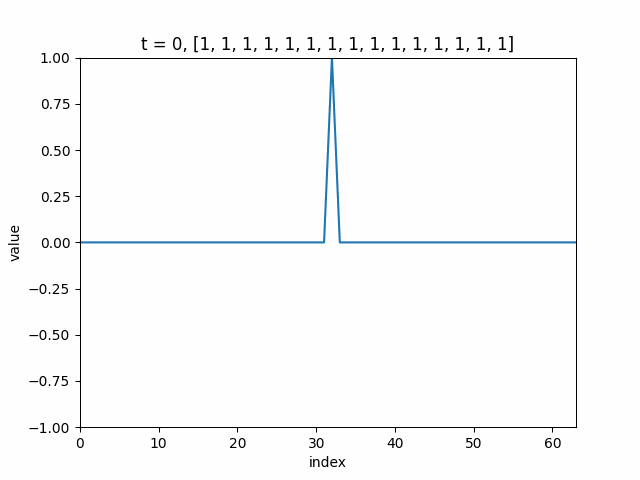

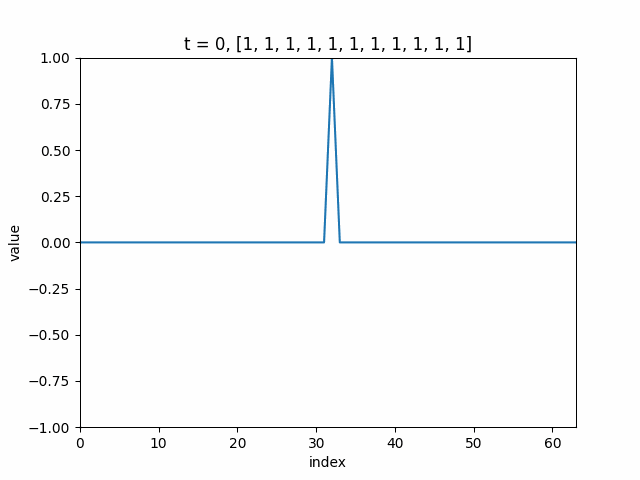

In [17]:
display(gif_1)
display(gif_2)